In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-tsv/new_train.tsv
/kaggle/input/test-tsv/new_test.tsv
/kaggle/input/tensorboardx/tensorboardx-2.6.4-py3-none-any.whl


In [85]:
#读入数据
import pandas as pd
train_df = pd.read_csv("/kaggle/input/train-tsv/new_train.tsv",
                       sep="\t", names=['text', 'label']) 
test_df = pd.read_csv("/kaggle/input/train-tsv/new_train.tsv", 
                       sep='\t', names=['text', 'label'])
train_df.head()
test_df.head()

#划分数据集
from sklearn.model_selection import train_test_split
train_texts, valid_texts, train_labels, valid_labels = train_test_split(
    train_df["text"], train_df["label"], test_size=0.2, random_state=42
)

#文本预处理
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text.split()

#文本向量化--bow方法
vocab = {}
tokenized_sentences = []

def build_bow(sentences):
    vocab = {} #vocab中单词的索引可用于后续填充bow矩阵
    tokenized_sentences = []
    for sent in sentences:
        tokens = preprocess_text(sent)
        tokenized_sentences.append(tokens)
        for word in tokens:
            if word not in vocab:
                vocab[word] = len(vocab)

    bow_matrix = torch.zeros(len(sentences), len(vocab), dtype=torch.float32)
        
    for i, token in enumerate(tokenized_sentences):
        for word in tokens:
            if word in vocab:
                bow_matrix[i][vocab[word]] += 1

    return bow_matrix, vocab
#--------检验函数是否正确---------
sentences = [
    "This movie is great!",
    "This movie is bad...",
    "I love this film."
]

X_bow, vocab = build_bow(sentences)

print("词表:", vocab)
print("BoW 矩阵:\n", X_bow)
#-------------------------------


#n-gram方法
def generate_ngrams(tokens, n=2):
    """
    从分词列表生成 n-grams，例如 bigram (n=2)
    ['this', 'is', 'good'] -> ['this is', 'is good']
    """
    if len(tokens) < n:
        return []
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]
    
def build_ngram_bow(sentences, n=2):
    vocab = {}
    tokenized_sentences = []
    #构建词表
    for sent in sentences:
        tokens = preprocess_text(sent)
        ngrams = generate_ngrams(tokens, n)
        features = tokens + ngrams
        tokenized_sentences.append(features)
        for word in features:
            if word not in vocab:
                vocab[word] = len(vocab)
    #初始化bow矩阵
    bow_matrix = torch.zeros(len(sentences), len(vocab), dtype=torch.float32)
    #填充bow矩阵
    for i, features in enumerate(tokenized_sentences):
            bow_matrix[i][vocab[word]] += 1

    return bow_matrix, vocab 
#--------检验函数是否正确---------
sentences = [
    "This movie is great!",
    "This movie is bad...",
    "I love this film."
]

X_bow, vocab = build_ngram_bow(sentences)

print("词表:", vocab)
print("BoW 矩阵:\n", X_bow)
#-------------------------------

#文本正式向量化
X_train_bow, vocab = build_bow(train_texts)#训练集

#测试集
X_valid_bow = torch.zeros(len(valid_texts), len(vocab), dtype=torch.float32)
for i, sent in enumerate(valid_texts):
    tokens = preprocess_text(sent)
    for word in tokens:
        if word in vocab:
            X_valid_bow[i][vocab[word]] += 1

#测试集
X_test_bow = torch.zeros(len(test_df["text"]), len(vocab), dtype=torch.float32)
for i, sent in enumerate(test_df["text"]):
    tokens = preprocess_text(sent)
    for word in tokens:
        if word in vocab:
            X_test_bow[i][vocab[word]] += 1

#标签转化为向量
y_train_tensor = torch.tensor(train_labels.values, dtype=torch.long)
y_valid_tensor = torch.tensor(valid_labels.values, dtype=torch.long)
y_test_tensor = torch.tensor(test_df["label"].values, dtype=torch.long)

#检查一下
print("训练集:", X_train_bow.shape, y_train_tensor.shape)
print("验证集:", X_valid_bow.shape, y_valid_tensor.shape)
print("测试集:", X_test_bow.shape, y_test_tensor.shape)

词表: {'this': 0, 'movie': 1, 'is': 2, 'great': 3, 'bad': 4, 'i': 5, 'love': 6, 'film': 7}
BoW 矩阵:
 tensor([[1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 1., 1., 1.]])
词表: {'this': 0, 'movie': 1, 'is': 2, 'great': 3, 'this movie': 4, 'movie is': 5, 'is great': 6, 'bad': 7, 'is bad': 8, 'i': 9, 'love': 10, 'film': 11, 'i love': 12, 'love this': 13, 'this film': 14}
BoW 矩阵:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
训练集: torch.Size([6822, 14411]) torch.Size([6822])
验证集: torch.Size([1706, 14411]) torch.Size([1706])
测试集: torch.Size([8528, 14411]) torch.Size([8528])


In [86]:
#初始化参数

#行数=词表大小 列数=标签种类的个数
W_row = X_train_bow.shape[1]
W_col = len(set(train_labels))

W = torch.randn(W_row, W_col, dtype=torch.float32, requires_grad=True)
b = torch.zeros(W_col, dtype=torch.float32, requires_grad=True)

num_classes = W_col
lr = 0.001

In [87]:
#训练循环

from torch.utils.data import DataLoader, TensorDataset

#把特征 X_train_tensor 和标签 y_train_tensor 打包在一起
train_dataset = TensorDataset(X_train_bow, y_train_tensor)
valid_dataset = TensorDataset(X_valid_bow, y_valid_tensor)

#为数据集划分batch，按batch读取TensorDataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

#前向传播
def forward(X, W, b):
    logits = X @ W + b  #线性层
    probs = torch.softmax(logits, dim=1)  #在类别数量维度上做softmax
    return probs

#损失函数
def cross_entropy_loss(probs, y):
    batch_size = y.size(0) #y为真实标签
    real_probs = probs[range(batch_size), y] + 1e-9 #从每一行的概率分布里，挑出真实类别对应的概率
    loss = -torch.log(real_probs).mean() #计算batch里面每一行的loss，并求均值
    return loss

#计算准确率
def accuracy(probs, y):
    preds = probs.argmax(dim=1)
    return (preds==y).float().mean().item()


In [88]:
#!pip install /kaggle/input/tensorboardx/tensorboardx-2.6.4-py3-none-any.whl


In [89]:
#import tensorboardX
#print(tensorboardX.__version__)


In [90]:
#from tensorboardX import SummaryWriter

#writer = SummaryWriter()

#%load_ext tensorboard

#%load_ext tensorboard

In [91]:
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

In [92]:
# 初始化列表
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

num_epochs = 50
for epoch in range(num_epochs):
    W.grad = None
    b.grad = None  # 清空梯度

    # ----------训练---------
    train_loss = 0
    train_acc = 0
    for X_batch, y_batch in train_loader:
        batch_size = X_batch.size(0)
        probs = forward(X_batch, W, b)
        loss = cross_entropy_loss(probs, y_batch)

        loss.backward()  # 反向传播

        # 参数更新
        with torch.no_grad():
            W -= lr * W.grad
            b -= lr * b.grad
            W.grad.zero_()
            b.grad.zero_()

        train_loss += loss.item() * batch_size
        train_acc += accuracy(probs, y_batch) * batch_size

    # ------验证--------
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            batch_size = X_batch.size(0)
            probs = forward(X_batch, W, b)
            loss = cross_entropy_loss(probs, y_batch)
            valid_loss += loss.item() * batch_size
            valid_acc += accuracy(probs, y_batch) * batch_size

    # 计算平均值
    train_loss /= len(train_dataset)
    valid_loss /= len(valid_dataset)
    train_acc /= len(train_dataset)
    valid_acc /= len(valid_dataset)

    # 保存到列表
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Valid Loss: {valid_loss:.4f} "
          f"Valid Acc: {valid_acc:.4f}")


Epoch 1/50 Train Loss: 4.2363 Train Acc: 0.2990 Valid Loss: 4.9472 Valid Acc: 0.1858
Epoch 2/50 Train Loss: 3.6609 Train Acc: 0.2990 Valid Loss: 4.9575 Valid Acc: 0.1870
Epoch 3/50 Train Loss: 3.1140 Train Acc: 0.2990 Valid Loss: 4.9694 Valid Acc: 0.1882
Epoch 4/50 Train Loss: 2.6234 Train Acc: 0.2990 Valid Loss: 4.9817 Valid Acc: 0.1852
Epoch 5/50 Train Loss: 2.2499 Train Acc: 0.2990 Valid Loss: 4.9921 Valid Acc: 0.1852
Epoch 6/50 Train Loss: 2.0297 Train Acc: 0.2990 Valid Loss: 4.9985 Valid Acc: 0.1870
Epoch 7/50 Train Loss: 1.9184 Train Acc: 0.2990 Valid Loss: 5.0011 Valid Acc: 0.1893
Epoch 8/50 Train Loss: 1.8518 Train Acc: 0.2990 Valid Loss: 5.0013 Valid Acc: 0.1893
Epoch 9/50 Train Loss: 1.7990 Train Acc: 0.2990 Valid Loss: 5.0004 Valid Acc: 0.1876
Epoch 10/50 Train Loss: 1.7513 Train Acc: 0.2990 Valid Loss: 4.9986 Valid Acc: 0.1864
Epoch 11/50 Train Loss: 1.7068 Train Acc: 0.2967 Valid Loss: 4.9964 Valid Acc: 0.1876
Epoch 12/50 Train Loss: 1.6656 Train Acc: 0.2974 Valid Loss: 4.

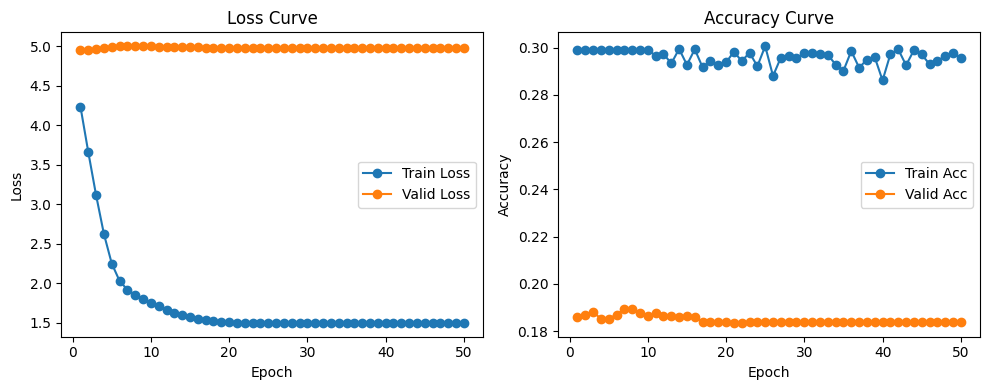

In [93]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Acc', marker='o')
plt.plot(epochs, valid_accs, label='Valid Acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
